In [23]:
%matplotlib notebook
from DataSets import *
from RegressionRun import *
#from MalardClient.MalardClient import MalardClient
#from MalardClient.DataSet import DataSet
#from MalardClient.BoundingBox import BoundingBox
#from MalardClient.DataSetQuery import DataSetQuery
#import datetime
#import os
#import numpy as np
#import json
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import seaborn as sns
import scipy

In [155]:
reg = RegressionRun(notebook=True)
# minT and maxT
bbx = reg.client.boundingBox(reg.inputDataSet)
minT = bbx.minT
maxT = bbx.maxT
# minX etc.
minX = 500000
maxX = 600000
minY = 0
maxY = 100000

bbx_in = BoundingBox(minX, maxX, minY, maxY, minT, maxT)

11:07:42, MainThread 140354470926144: RegressionRun INFO Process started


In [57]:


results = reg.gridcellRegression(bbx_in)

12:33:42, MainThread 140670513055552: RegressionRun INFO Process started
12:33:42, MainThread 140670513055552: RegressionRun INFO Filtering dataset=parentDataSet=mtngla, datSet=ReadyHim2, region=himalayas with criteria [{'column': 'power', 'op': 'gt', 'threshold': 10000}, {'column': 'coh', 'op': 'gt', 'threshold': 0.6}, {'column': 'demDiff', 'op': 'lt', 'threshold': 100}, {'column': 'demDiffMad', 'op': 'lt', 'threshold': 10}, {'column': 'demDiff', 'op': 'gt', 'threshold': -100}, {'column': 'demDiffMad', 'op': 'gt', 'threshold': -10}, {'column': 'refDifference', 'op': 'gt', 'threshold': -150}, {'column': 'refDifference', 'op': 'lt', 'threshold': 150}, {'column': 'within_DataSet', 'op': 'gt', 'threshold': 1}]
12:35:04, MainThread 140670513055552: RegressionRun INFO Result message: status=Success, message=Success
12:35:05, MainThread 140670513055552: DataSets INFO Linear regression...
12:35:05, MainThread 140670513055552: DataSets INFO Robust regression...
12:35:05, MainThread 14067051305

In [156]:
filters = reg.config('filters')
result = reg.client.executeQuery(reg.inputDataSet, bbx_in, projections=[], filters=filters)
data = PointDataSet(result.resultFileName, reg.projection)
data.data.shape[0]

106916

In [39]:
data.data.columns

Index(['index', 'lon', 'lat', 'elev', 'heading', 'demDiff', 'demDiffMad',
       'demDiffMad2', 'phaseAmb', 'meanDiffSpread', 'wf_number', 'sampleNb',
       'power', 'powerdB', 'phase', 'phaseS', 'phaseSSegment',
       'phaseConfidence', 'coh', 'x', 'y', 'time', 'swathFileId',
       'within_Debris', 'within_DataSet', 'refElevation', 'refDifference'],
      dtype='object')

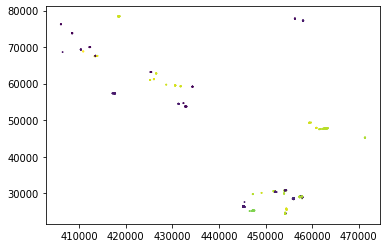

In [8]:
%matplotlib inline
plt.scatter(x=data.data.x,y=data.data.y, s=0.7, c=data.data.wf_number)

In [9]:
results

{'regression.rsquared': 0.004958838236633123,
 'regression.c': -2.57037671295777e-08,
 'regression.c.se': 1.2661191449355721e-08,
 'regression.c.year': -0.8105940001983624,
 'regression.c.se.year': 0.399283333546882,
 'regression.const': 25.214711186052167,
 'regression.const.se': 18.011530514986173,
 'regression.count': 829.0,
 'regression.const.pvalue': 0.1619121364724773,
 'regression.c.pvalue': 0.042663720622734005,
 'regression.const.tvalue': 1.3999205211946155,
 'regression.c.tvalue': -2.0301223018695973,
 'regression.c.conf_interval.low': -1.5943219579145693,
 'regression.c.conf_interval.high': -0.026866042482155333,
 'regression.const.conf_interval.low': -10.138980891345302,
 'regression.const.conf_interval.high': 60.56840326344964,
 'regression.robust.c': -2.329011850768183e-08,
 'regression.robust.c.se': 1.1520189649963635e-08,
 'regression.robust.c.year': -0.7344771772582542,
 'regression.robust.c.se.year': 0.3633007008012532,
 'regression.robust.const': 21.647558330918592,


In [157]:
filters = reg.config('filters')

queried_data = reg.client.executeQuery(reg.inputDataSet, bbx_in, projections=[], filters=filters)

data = PointDataSet(queried_data.resultFileName, reg.projection)
# release cache of file
reg.client.releaseCacheHandle(queried_data.resultFileName)

month = []
for i, row in data.data.iterrows():
    date = datetime.datetime.utcfromtimestamp(data.data.time[i])
    month.append(date.month)
data.data['month'] = month

results = {}
if data.data.shape[0]>2:
    # model variables
    vals = np.asarray([data.data.time])
    vals = np.transpose(vals)
    vals = sm.add_constant(vals)
    elev = data.data.refDifference

    # Create model and fit it (least squares)
    #model = sm.OLS(elev, vals)
    #results = model.fit()
    # OR robust model -- note that it won't have r squared
    #model = sm.RLM(elev, vals)
    # OR weithed model
    #weights = range(1,len(elev)+1)
    #weights = data.data.power
    # weights according to script
    power = data.data.power*data.data.power
    w = power/max(power)
    weights = w*w
    
    # mask huge elevation differences out
    mask = abs(elev-np.median(elev))>(3*np.std(elev))
    weights = np.where(mask,0,w)
    
    model = sm.WLS(elev, vals, weights)

    #results = model.fit(cov_type='HAC',cov_kwds={'maxlags':1})
    results = model.fit()

    regression_results = {}

    regression_results['regression.rsquared'] = results.rsquared
    regression_results['regression.c'] = results.params.x1
    regression_results['regression.c.se'] = results.bse.x1
    regression_results['regression.c.year'] = results.params.x1*31536000
    regression_results['regression.c.se.year'] = results.bse.x1*31536000
    regression_results['regression.const'] = results.params.const
    regression_results['regression.const.se'] = results.bse.const
    regression_results['regression.count'] = results.nobs
    
    regression_results['regression.const.pvalue'] = results.pvalues.const 
    regression_results['regression.c.pvalue'] = results.pvalues.x1 
    regression_results['regression.const.tvalue'] = results.tvalues.const 
    regression_results['regression.c.tvalue'] = results.tvalues.x1
    
    intervals = results.conf_int(alpha=0.05, cols=None)
    regression_results['regression.c.conf_interval.low'] = intervals[intervals.index=='x1'].values[0][0]*31536000
    regression_results['regression.c.conf_interval.high'] = intervals[intervals.index=='x1'][1].values[0]*31536000
    regression_results['regression.const.conf_interval.low'] = intervals[intervals.index=='const'][0].values[0]
    regression_results['regression.const.conf_interval.high'] = intervals[intervals.index=='const'][1].values[0]
    
    results.conf_int(alpha=0.05, cols=None)
    
    
    print(results.summary())

                            WLS Regression Results                            
Dep. Variable:          refDifference   R-squared:                       0.122
Model:                            WLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                 1.482e+04
Date:                Tue, 03 Dec 2019   Prob (F-statistic):               0.00
Time:                        11:08:08   Log-Likelihood:                   -inf
No. Observations:              106916   AIC:                               inf
Df Residuals:                  106914   BIC:                               inf
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.7172      0.588    113.436      0.0

In [215]:
results.resid.std()

7.917137634516467

In [214]:
results.wresid

0       -1.542606
1       -2.473770
2       -3.446489
3       -4.497785
4       -5.228281
5       -5.434268
6       -5.205400
7       -4.962808
8       -4.114784
9       -2.860482
10      -1.696937
11      -0.025801
12      -0.502782
13      -1.157898
14      -1.646224
15      -1.810071
16      -1.357437
17      -0.907347
18      -0.480939
19      -1.785781
20      -4.738943
21      -9.812261
22     -14.868947
23     -16.242444
24     -13.310643
25      -8.721671
26      -4.407473
27      -2.639315
28      -1.979278
29      -1.500778
          ...    
5776    -5.470311
5777    -4.639937
5778    -3.269905
5779    -1.395703
5780    -1.938535
5781    -2.237640
5782    -1.995945
5783    -1.808991
5784    -2.409013
5785    -3.127815
5786    -4.217166
5787    -4.509915
5788    -3.847221
5789    -3.109453
5790    -2.401184
5791    -0.000000
5792    -0.000000
5793    -2.447507
5794    -0.000000
5795    -0.000000
5796    -0.000000
5797    -0.000000
5798    -0.000000
5799     0.169648
5800    -0

array([[ 4.96132400e+04, -3.32815502e-05],
       [-3.32815502e-05,  2.23336041e-14]])

In [208]:
results.conf_int(alpha=0.32, cols=None)

,0,1
const,-1.617283e+01,-1.320045e+01
x1,1.124872e-08,1.334211e-08


In [142]:
intervals[intervals.index=='const'].values[0][0]
#intervals[intervals.index=='const'].values[0]

65.2364344533844

In [ ]:
print(results.get_robustcov_results(cov_type='HC3').summary())

In [7]:
res2 = model.fit(cov_type='HC0')
print(res2.summary())

                            WLS Regression Results                            
Dep. Variable:          refDifference   R-squared:                       0.117
Model:                            WLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     7354.
Date:                Fri, 15 Nov 2019   Prob (F-statistic):               0.00
Time:                        07:59:02   Log-Likelihood:                   -inf
No. Observations:              109053   AIC:                               inf
Df Residuals:                  109051   BIC:                               inf
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         66.3951      0.821     80.880      0.0

In [80]:
pd.DataFrame([weights,data.data.power])

,0,1,2,3,4,5,6,7,8,9,...,819,820,821,822,823,824,825,826,827,828
0,0.073467,0.172515,0.225646,0.132030,0.052209,0.047307,0.107176,0.222858,0.321467,0.254794,...,0.164957,0.174972,0.101072,0.040734,0.096012,0.200489,0.274461,0.191194,0.084550,0.035200
1,14590.706055,22358.533203,25570.798828,19559.869141,12299.942383,11708.251953,17622.955078,25412.312500,30520.960938,27172.203125,...,21863.263672,22517.177734,17113.779297,10864.430664,16679.875000,24103.240234,28201.369141,23537.861328,15652.606445,10099.522461


In [209]:
regression_results

{'regression.rsquared': 0.022975902258400738,
 'regression.c': 1.2295412521461202e-08,
 'regression.c.se': 1.0524360566297202e-09,
 'regression.c.year': 0.38774812927680047,
 'regression.c.se.year': 0.033189623481874854,
 'regression.const': -14.6866362723843,
 'regression.const.se': 1.4943432909438923,
 'regression.count': 5806.0,
 'regression.const.pvalue': 1.277771270852148e-22,
 'regression.c.pvalue': 3.4785770904968656e-31,
 'regression.const.tvalue': -9.828154187454198,
 'regression.c.tvalue': 11.682811933330703,
 'regression.c.conf_interval.low': 0.3226840942025564,
 'regression.c.conf_interval.high': 0.45281216435104454,
 'regression.const.conf_interval.low': -17.616106211928262,
 'regression.const.conf_interval.high': -11.757166332840338}

In [81]:
regression_results

{'regression.rsquared': 0.0016966503392643606,
 'regression.c': 1.5380843831225152e-08,
 'regression.c.se': 1.3076087761066814e-08,
 'regression.c.year': 0.48505029106151637,
 'regression.c.se.year': 0.41236750363300306,
 'regression.const': -29.22046886698464,
 'regression.const.se': 18.122543961752537,
 'regression.count': 829.0}

In [177]:
data.data.columns

Index(['index', 'lon', 'lat', 'elev', 'heading', 'demDiff', 'demDiffMad',
       'demDiffMad2', 'phaseAmb', 'meanDiffSpread', 'wf_number', 'sampleNb',
       'power', 'powerdB', 'phase', 'phaseS', 'phaseSSegment',
       'phaseConfidence', 'coh', 'x', 'y', 'time', 'swathFileId',
       'within_Debris', 'within_DataSet', 'refElevation', 'refDifference'],
      dtype='object')

In [66]:
# calculate regression prediction
minTime = data.data.time.min()
maxTime = data.data.time.max()
# calcualte prediction
minTimeValue = regression_results['regression.c']*minTime+regression_results['regression.const']
maxTimeValue = regression_results['regression.c']*maxTime+regression_results['regression.const']
predict_v = [minTimeValue,maxTimeValue]

# calculate upper error
minTimeValue = (regression_results['regression.c']+regression_results['regression.c.se'])*minTime+regression_results['regression.const']+regression_results['regression.const.se']
maxTimeValue = (regression_results['regression.c']+regression_results['regression.c.se'])*maxTime+regression_results['regression.const']+regression_results['regression.const.se']
predict_eup = [minTimeValue,maxTimeValue]

# calculate lower error
minTimeValue = (regression_results['regression.c']-regression_results['regression.c.se'])*minTime+regression_results['regression.const']-regression_results['regression.const.se']
maxTimeValue = (regression_results['regression.c']-regression_results['regression.c.se'])*maxTime+regression_results['regression.const']-regression_results['regression.const.se']
predict_elow = [minTimeValue,maxTimeValue]

<IPython.core.display.Javascript object>


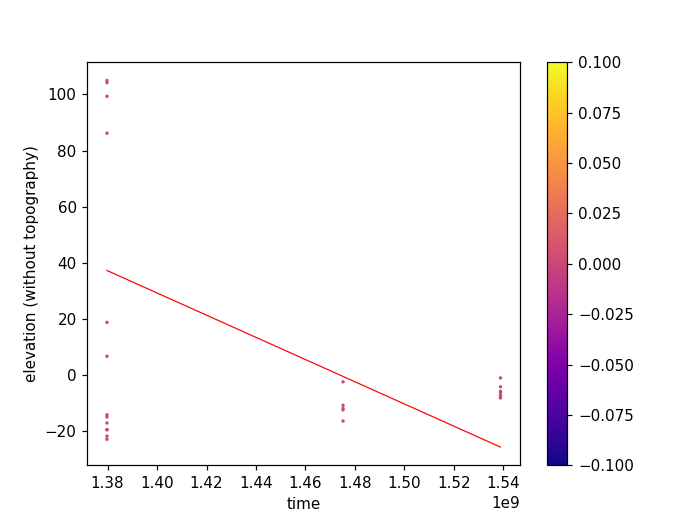

Text(0, 0.5, 'elevation (without topography)')

In [67]:
#data.data.plot(type='scatter',x='time', y='refDifference')
%matplotlib notebook

sc= plt.scatter(x=data.data.time, y=data.data.refDifference, c=mask, marker='.', s=6, cmap='plasma')
plt.colorbar(sc)
plt.plot([minTime,maxTime], predict_v, color='red', linewidth=0.8)
#plt.plot([minTime,maxTime], predict_elow, color='red', linewidth=0.8)
#plt.plot([minTime,maxTime], predict_eup, color='red', linewidth=0.8)
#plt.xlim(-50,50)
plt.xlabel('time')
plt.ylabel('elevation (without topography)')

<IPython.core.display.Javascript object>


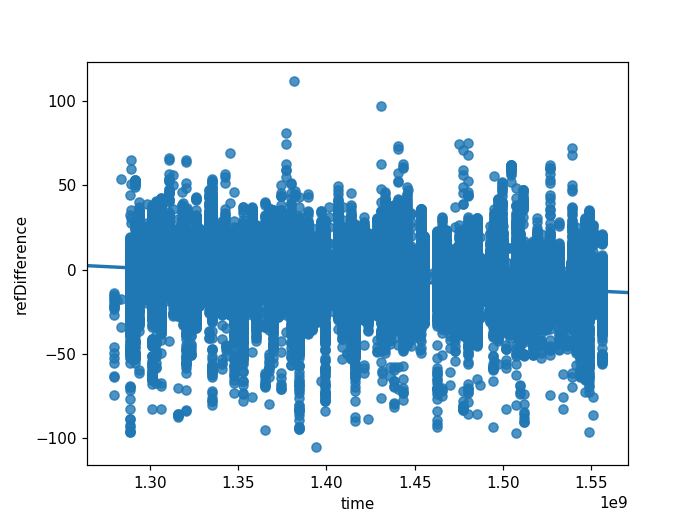

In [14]:
import seaborn as sns
%matplotlib notebook
sns.regplot(data.data.time, data.data.refDifference)

In [32]:
data.data.refDifference.std(), data.data.refDifference.sem()

(25.90313328934759, 0.899653005220245)

In [36]:
math.sqrt(pow(regression_results['regression.c.se.year'],2)+pow(data.data.refDifference.sem(),2))

0.9883161156056298

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
# generate random data
np.random.seed(24)
x = np.random.uniform(-5,5,25)
ϵ = 2*np.random.randn(25)
y = 2*x+ϵ

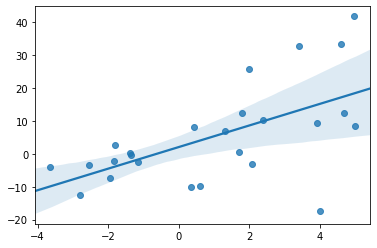

In [28]:
# alternate error as a function of x
ϵ2 = ϵ*(x+5)
y2 = 2*x+ϵ2
#sns.regplot(x,y2);
sns.regplot(x,y2,x_ci='sd');

In [124]:

x1 = np.array([[0, 1, 2, 0, 0],[2, 1, 0, 3, 2],[4, 8, 4, 7, 4],[8, 8, 8, 8, 8]])
x = np.array([[0, 2, 4,8], [1, 1, 8,8], [2, 0, 4,8],[0, 3, 7,8],[0, 2, 4,8]])
eleve=np.array([data.data.time,list(np.ones(data.data.refDifference.size))])

In [122]:
weights

array([0.07064969, 0.14234588, 0.30266696, 0.5027826 , 0.47965172,
       0.26780203, 0.11456498, 0.04827794, 0.11436996, 0.2552918 ,
       0.37853697, 0.28636697, 0.13989076, 0.06224498, 0.29465875,
       0.4588251 , 0.30876264, 0.7129081 , 0.73919076, 0.53589314,
       0.81123245, 0.96233404, 1.        , 0.8232147 , 0.4991328 ],
      dtype=float32)

In [126]:
cov=np.cov(eleve, aweights=weights)
cov

array([[3.65381235e+15, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00]])

In [44]:
np.var([4,8,4,7,4],ddof=1)

3.8

In [33]:
np.sqrt(np.diag(cov)[0])*31536000

28206655.895373344

In [ ]:
error=np.sqrt(np.diag(cov_matrix)[0])*31536000

In [171]:
w=[1,1,1]
time=[1,2,3]
el=[10,9,7]
indep=np.array([time,list(np.ones(len(time)))])
print(indep)
cov=np.cov(indep, aweights=w)
print(cov)

[[1. 2. 3.]
 [1. 1. 1.]]
[[1. 0.]
 [0. 0.]]


In [59]:
print()
print(wsqrt*indep)

[[1.         1.        ]
 [1.41421356 0.70710678]
 [5.19615242 1.73205081]]
[[1.         1.        ]
 [1.41421356 0.70710678]
 [5.19615242 1.73205081]]


In [116]:
w=[1,0.5,3]
time=[1,2,3]
el=[10,9,7]

# diagonal of weights
diag = scipy.sparse.diags(np.sqrt(w), 0, dtype=float)
diag.toarray()
wsqrt = diag.toarray()
# transpose of elevation
dep=np.mat(el).T
#indep=np.mat([list(data.data.time),list(np.ones(data.data.refDifference.size)), list(data.data.power)]).T
indep=np.mat([time,list(np.ones(len(time)))]).T
print(indep)
# compute the inverse of the model matrix
pinv=np.transpose(np.multiply(np.sqrt(w),[time,np.ones(len(time))]))
#pinv=wsqrt*indep
pinv = np.linalg.pinv(pinv)
print('pinv')
print(pinv)
#G_inv = pinv*wsqrt
p1=pinv[0]*np.sqrt(w)
p2=pinv[1]*np.sqrt(w)
G_inv=[p1,p2]
print('G_inv')
print(G_inv)
# compute the model coefficients
coeff = G_inv*dep
print('coeff')
print(coeff)

d_modelled = indep*coeff
print('d_modelled')
print(d_modelled)
d_diff = dep-d_modelled
print('d_diff')
print(d_diff)
# vardata is diagonal of square of differences
d_diff_pow = np.square(d_diff)
print('d_diff_pow')
print(d_diff_pow)
#varData =np.diag(np.diag(d_diff*d_diff.T))
#print('varData')
#print(varData)
# calculate unit model covariance matrix

d_diff_pow_array=np.squeeze(np.asarray(d_diff_pow))
g1=G_inv[0]*d_diff_pow_array
g2=G_inv[1]*d_diff_pow_array
G_var = [g1,g2]
#G_var = G_inv*varData
print('G_var')
print(G_var)
cov_matrix = np.mat(G_var)*np.mat(G_inv).T
print('\n')
#return (coeff, cov_matrix)
print('cov_matrix')
print(cov_matrix)
print('\n')
print(coeff)
error=np.sqrt(np.diag(cov_matrix)[0])*31536000

rate=coeff[0,0]*31536000
print(error, rate)
#
#coeff
#[[-1.53571429]
#[11.64285714]]

#G_inv
#[[-0.46428571 -0.07142857  0.53571429]
#[ 1.35714286  0.28571429 -0.64285714]]

#d_modelled
#[[10.10714286]
#[ 8.57142857]
#[ 7.03571429]]

#d_diff
#[[-0.10714286]
#[ 0.42857143]
#[-0.03571429]]

#varData
#[[0.01147959 0.         0.        ]
# [0.         0.18367347 0.        ]
# [0.         0.         0.00127551]]

#G_var
#[[-0.00532981 -0.01311953  0.00068331]
#[ 0.01557945  0.05247813 -0.00081997]]

# cov_matrix
#[[ 0.00377772 -0.01142102]
#[-0.01142102  0.03666441]]

[[1. 1.]
 [2. 1.]
 [3. 1.]]
pinv
[[-0.46428571 -0.10101525  0.30929479]
 [ 1.35714286  0.40406102 -0.37115374]]
G_inv
[array([-0.46428571, -0.07142857,  0.53571429]), array([ 1.35714286,  0.28571429, -0.64285714])]
coeff
[[-1.53571429]
 [11.64285714]]
d_modelled
[[10.10714286]
 [ 8.57142857]
 [ 7.03571429]]
d_diff
[[-0.10714286]
 [ 0.42857143]
 [-0.03571429]]
d_diff_pow
[[0.01147959]
 [0.18367347]
 [0.00127551]]
G_var
[array([-0.00532981, -0.01311953,  0.00068331]), array([ 0.01557945,  0.05247813, -0.00081997])]


cov_matrix
[[ 0.00377772 -0.01142102]
 [-0.01142102  0.03666441]]


[[-1.53571429]
 [11.64285714]]
1938302.9286548262 -48430285.71428566


In [288]:
#3716553.2419165424 -47304000.00000007
#1938302.9286548262 -48430285.71428566
#coeff = G_inv*dep
x=np.array([[1,2,3,4]])

varData = np.diag(np.diag(x*x.T))
varData
print(x*x.T)
print(np.square(x).shape)
print(np.diag(np.square(x)[0]))

[[ 1  2  3  4]
 [ 2  4  6  8]
 [ 3  6  9 12]
 [ 4  8 12 16]]
(1, 4)
[[ 1  0  0  0]
 [ 0  4  0  0]
 [ 0  0  9  0]
 [ 0  0  0 16]]


In [248]:
np.linalg.inv(coeff)*dep

LinAlgError: Last 2 dimensions of the array must be square

In [228]:
np.diag(d_diff)

array([0.02777778, 0.11111111, 0.02777778])

In [ ]:
time=[1,2,3]
el=[10,9,7]

In [217]:
# diagonal of weights
diag = scipy.sparse.diags(np.sqrt(weights), 0, dtype=float)
diag.toarray()
# transpose of elevation
dep=np.mat(data.data.refDifference).T
#indep=np.mat([list(data.data.time),list(np.ones(data.data.refDifference.size)), list(data.data.power)]).T
indep=np.mat([data.data.time,list(np.ones(data.data.refDifference.size))]).T
#diag = scipy.sparse.diags([0.5,0.25,0.5], 0, dtype=float)
wsqrt = diag.toarray()
#indep = np.mat([1,2,3]).T
#dep = np.mat([150,300,400]).T
#weights, dep, indep
print(indep.size, dep.size, weights2.size, weights2[0].size)
# G is matrix of indep
# d is transposed elevation matrix
# w is diagonals matrix of weights
# compute the inverse of the model matrix
#wsqrt = np.sqrt(weights2)
G_inv = np.linalg.pinv(wsqrt*indep)*wsqrt
#G_inv
# compute the model coefficients
coeff = G_inv*dep

d_modelled = indep*coeff
d_diff = dep-d_modelled
print(d_diff)
d_diff = d_diff*d_diff.T
varData = np.diag(np.diag(d_diff))
# calculate unit model covariance matrix
cov_matrix = G_inv*varData*G_inv.T

#return (coeff, cov_matrix)
print(cov_matrix)
print('\n')
#print(coeff)

error=np.sqrt(np.diag(cov_matrix)[0])*31536000
rate=coeff[0,0]*31536000
print(error, rate)
print(np.diag(cov_matrix)[0])

11612 5806 33709636 5806
[[ -7.03749283]
 [ -7.82954048]
 [ -8.11254436]
 ...
 [-20.78225805]
 [-13.87219849]
 [-12.39789905]]
[[ 3.78093867e-18 -5.26369358e-09]
 [-5.26369358e-09  7.33948268e+00]]


0.06132060393907687 0.3877481292768009
3.780938673162888e-18


In [211]:
regression_results['regression.c.se.year'],regression_results['regression.c.year']

(0.033189623481874854, 0.38774812927680047)

In [160]:
# NOELS CODE
refDiff=data.data.refDifference
#refDiff = np.random.normal(size=500000)
time = data.data.time
#time = np.random.normal(size=500000)
ones=list(np.ones(data.data.refDifference.size))
#ones=list(np.ones(len(time)))
#weights=weights
#weights = np.random.rand(500000)
sqw = np.sqrt(weights)

In [161]:
# transpose of elevation
dep=np.mat(refDiff).T
#indep=np.mat([list(data.data.time),list(np.ones(data.data.refDifference.size)), list(data.data.power)]).T
indep=np.mat([time,ones]).T

In [162]:
# compute the inverse of the model matrix
trans=np.transpose(np.multiply(sqw,[time,ones]))

In [163]:
pinv = np.linalg.pinv(trans)

In [164]:
G_inv=[pinv[0]*sqw,pinv[1]*sqw]

In [165]:
# compute the model coefficients
coeff = G_inv*dep
d_modelled = indep*coeff
d_diff = dep-d_modelled

In [166]:
d_diff_pow = np.square(d_diff)
d_diff_pow_array=np.squeeze(np.asarray(d_diff_pow))

In [167]:
G_var = [G_inv[0]*d_diff_pow_array,G_inv[1]*d_diff_pow_array]

In [168]:
cov_matrix = np.mat(G_var)*np.mat(G_inv).T

In [169]:
#return (coeff, cov_matrix)
print('cov_matrix')
print(cov_matrix)
print('\n')
print(coeff)
error=np.sqrt(np.diag(cov_matrix)[0])*31536000

rate=coeff[0,0]*31536000
print(error, rate)

cov_matrix
[[ 3.42769999e-19 -4.79488559e-10]
 [-4.79488559e-10  6.72444029e-01]]


[[-5.05817025e-08]
 [ 6.67171918e+01]]
0.018463243964413154 -1.5951445699759963


In [158]:
regression_results['regression.c.se.year'],regression_results['regression.c.year']

(0.013104665731186672, -1.5951445699759954)

In [159]:
np.sqrt(results.cov_params()['x1']['x1'])*31536000

0.013104665731186672